# 10-714 Final Project Group ID 43

## Team Names:
- Royce Ang `(royceang)`
- Benjamin Liu `(bliu3)`
- Ian Shen

Note: the above name(s) follows the following convention `<Name><(AndrewID)>`


---


## Project Scope
Our project aims to extend Needle by implementing a comprehensive suite of advanced and adaptive optimization algorithms beyond the existing Adam implementation. Building on needle's autograd and tensor computation engine, we will add optimizers such as AdamW, RMSProp, Adagrad, LAMB and AdaBelief, supporting both dense and sparse parameter udpates. Each optimizer will be designed as a modular, extensible class fully compatible with Needle's computation grpah and device abstraction. We will reference key research papers including Loschilov & Hutter (2019) for AdamW, you et al. (2020) for LAMB and Zhuang et al. (2020) for AdaBelief. Our evaluation will include convergence speed, trianing stability and scalability benchamrks on standard datasets (CIFAR-10), demonstrating quantitative improvements in optimization performance within the Needle framework.

To strengthen it, you could briefly describe the planned optimizer API (how users switch optimizers, handle hyper-parameters, and sparse updates) and spell out the key evaluation plots you expect to show (e.g., loss/accuracy vs. steps and wall-clock time). // Rewrite this part



---

# Content
- **Section 1:** Initial pre-setup | Includes cloning of repository
- **Section 2:** Pre-test | Ensuring that `RestNet9` and `Cifar10` implementations are correct
- **Section 3:** API Optimization and Configuration Setup | Explanation on how we have engineered an efficient way to perform ablation testing
- **Section 4:** Optimizers
- **Section 5:** Final Thoughts




---


# Section 1: Initial pre-setup

In [1]:
# Enter the private github token provided via 1password
import os, getpass
os.environ["GITHUB_TOKEN"] = getpass.getpass("GitHub PAT (read-only): ")

GitHub PAT (read-only): ··········


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714
%cd /content/drive/MyDrive/10714
# !git clone --branch <branch-name> --single-branch https://$GITHUB_TOKEN@github.com/royc0003/10714-dlsys-final-project-group-43.git
# !git clone https://$GITHUB_TOKEN@github.com/royc0003/10714-dlsys-final-project-group-43.git
!git clone --branch fix_train_test --single-branch https://$GITHUB_TOKEN@github.com/royc0003/10714-dlsys-final-project-group-43.git
%cd /content/drive/MyDrive/10714/10714-dlsys-final-project-group-43
!pip3 install pybind11
!pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
#del os.environ["GITHUB_TOKEN"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/10714
Cloning into '10714-dlsys-final-project-group-43'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (295/295), done.
remote: Total 372 (delta 86), reused 343 (delta 62), pack-reused 0 (from 0)
Receiving objects: 100% (372/372), 5.95 MiB | 9.92 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Updating files: 100% (196/196), done.
/content/drive/MyDrive/10714/10714-dlsys-final-project-group-43
  Cloning https://github.com/dlsys10714/mugrade.git to /tmp/pip-req-build-nl0c2243
  Running command git clone --filter=blob:none --quiet https://github.com/dlsys10714/mugrade.git /tmp/pip-req-build-nl0c2243
  Resolved https://github.com/dlsys10714/mugrade.git to commit ac73f725eb2ce0e2c6a38fa540035ee970b8b873
  Preparing metadata (setup.py) ...

In [3]:
!make

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Python: /usr/local/bin/python (found version "3.12.12") found components: Development Interpreter Development.Module

In [4]:
%set_env PYTHONPATH ./python
%set_env NEEDLE_BACKEND nd

env: PYTHONPATH=./python
env: NEEDLE_BACKEND=nd


In [5]:
import sys
sys.path.append('./python')

In [6]:
# Download the datasets you will be using for this assignment
import urllib.request
import os

!mkdir -p './data/ptb'
# Download Penn Treebank dataset
ptb_data = "https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb."
for f in ['train.txt', 'test.txt', 'valid.txt']:
    if not os.path.exists(os.path.join('./data/ptb', f)):
        urllib.request.urlretrieve(ptb_data + f, os.path.join('./data/ptb', f))

# Download CIFAR-10 dataset
if not os.path.isdir("./data/cifar-10-batches-py"):
    urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "./data/cifar-10-python.tar.gz")
    !tar -xvzf './data/cifar-10-python.tar.gz' -C './data'

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1




---
# Section 2: Pre-tests


# Restnet9
Here we intend to train ResNet on CIFAR10.
The following tests are to ascertain the validity of our resnet9 implementation.

In [ ]:
!python3 -m pytest -l -v -k "resnet9"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/10714-dlsys-final-project-group-43
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.42
collected 1915 items / 1913 deselected / 2 selected                            

tests/hw4/test_conv.py::test_resnet9[needle.backend_ndarray.ndarray_backend_cpu] PASSED [ 50%]
tests/hw4/test_conv.py::test_resnet9[needle.backend_ndarray.ndarray_backend_cuda] PASSED [100%]

====================== 2 passed, 1913 deselected in 4.82s ======================


## CIFAR-10 dataset Initial Setup

Initial setup to support the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image classification dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50k training images and 10k test images.



In [ ]:
!python3 -m pytest -l -v -k "test_cifar10"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/10714-dlsys-final-project-group-43
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.42
collected 1915 items / 1905 deselected / 10 selected                           

tests/hw4/test_cifar_ptb_data.py::test_cifar10_dataset[True] PASSED      [ 10%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_dataset[False] PASSED     [ 20%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-True-1] PASSED [ 30%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-True-15] PASSED [ 40%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-False-1] PASSED [ 50%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-False-15] PASSED [ 60%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cuda-True-1] PASSED [ 70%]
tests/hw4/test_cifar_ptb_data.py::test



---
# Section 3:  API Optimization and Configuration Setup

# API Optimization and Configuration Setup
The goal of this section is to showcase how we have exposed config-driven APIs that extends existing `Optimizer` class to allow optimal ablation testing. This simplifies how users can test their optimizer and training strategy.

## Explanation of config-driven API exposed
Here we will utilize the following config as an example:
```json
config = {
    "optimizer": {
        "name": "adam",
        "lr": 1e-3,
        "weight_decay": 5e-4,
    },
    "run": {
        "epochs": 2,
        "seed": 42,
        "max_batches": 128,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}
```
### Config Structure Explanation
1. **"optimizer" Section** (Required for config-driven optimizer selection)
```
"optimizer": {
    "name": "adam",           # Optimizer name (must be registered via register_optimizer)
    "lr": 1e-3,               # Learning rate (overrides optimizer defaults)
    "weight_decay": 5e-4,     # Weight decay/L2 regularization coefficient
}
```
- **name:** Must match a registered optimizer (e.g., "adam", "sgd"). The factory looks it up in the registry.
- **lr, weight_decay:** Hyperparameters passed to the optimizer constructor. You can also nest optimizer-specific params under
```json
  "optimizer": {
      "name": "adam",
      "lr": 1e-3,
      "hyperparams": {
          "beta1": 0.9,
          "beta2": 0.999,
          "eps": 1e-8
      }
  }
```
2. **"run" Section** (Training execution settings)
```json
"run": {
    "epochs": 2,              # Number of training epochs (overrides n_epochs parameter)
    "seed": 42,               # Random seed for reproducibility
    "max_batches": 128,       # Optional: cap batches per epoch (useful for quick tests)
    "verbose": True,          # Print epoch start/finish messages with timing
    "device": "cuda" if use_cuda else "cpu",  # Metadata only (actual device set via DataLoader)
}
```
- **epochs:** Overrides the n_epochs argument to train_cifar10.
- **seed:** Sets np.random.seed() for reproducibility.
- **max_batches:** Limits batches per epoch (useful for quick tests/debugging).
- **verbose**: Enables epoch start/finish logging with elapsed time.
- **device:** Metadata string; actual device placement is set when creating the model and DataLoader.
3. **"loss" Section** (Loss function configuration)
```json
"loss": {
    "name": "SoftmaxLoss",    # Loss function name (must exist in needle.nn)
}
```
- **name**: Must match a class in needle.nn (e.g., "SoftmaxLoss"). The factory instantiates it via getattr(nn, name)().
4. **Top-Level Flags**
```json
"return_history": True,       # Return full training history (list of per-epoch metrics)
"progress_bar": True,        # Show tqdm progress bar during training
```
- **return_history**: When True, train_cifar10 returns (final_acc, final_loss, history) where history is a list of dicts with epoch metrics.
- **progress_bar**: When True, displays a live progress bar for each epoch showing batch progress and ETA.

### How It Works
1. **Config parsing**: train_cifar10 reads the config and extracts sections.
2. **Optimizer creation**: _resolve_optimizer() checks config["optimizer"] first. If present, it calls build_optimizer_from_config() which:
- Looks up the optimizer by name in the registry
- Merges defaults with your hyperparameters
- Instantiates the optimizer class
3. **Loss instantiation**: _instantiate_loss() creates the loss module from config["loss"].
4. **Training loop**: Uses config["run"] settings (epochs, seed, max_batches, verbose) and tracks history if return_history=True.
#### Example Usage
```
# Config-driven (recommended)
config = {
    "optimizer": {"name": "adam", "lr": 1e-3, "weight_decay": 5e-4},
    "run": {"epochs": 2, "seed": 42, "max_batches": 128, "verbose": True},
    "loss": {"name": "SoftmaxLoss"},
    "return_history": True,
    "progress_bar": True,
}

final_acc, final_loss, history = train_cifar10(
    model,
    train_loader,
    config=config  # Config takes precedence over optimizer/lr/weight_decay params
)

# Traditional API (still works, but config overrides)
final_acc, final_loss = train_cifar10(
    model,
    train_loader,
    optimizer=ndl.optim.Adam,  # Ignored if config["optimizer"] exists
    lr=0.001,                  # Ignored if config["optimizer"]["lr"] exists
    config=config
)
```
This design lets you switch optimizers and hyperparameters by changing the config, making it easy to run experiments and sweeps.


### Adam Baseline Configuration and Training
Run the following cells `in order` to run a quick Adam baseline through the new config-driven API. Adjust the paths, epochs, or hyperparameters as needed for your experiment.

#### Step 1: Expose Data Builders
Here we expose `build_cifar_10_model` and `build_cifar10_train_loader` for the purpose of reusability in our ablation tests.

In [7]:
import os
import sys

import needle as ndl
import needle.nn as nn
from apps.models import ResNet9
from apps.simple_ml import train_cifar10, split_cifar10_train_test

# Data builders --------------------------------------------------------------
def build_cifar10_model(device=None, dtype="float32"):
    device = device or ndl.cpu()
    return ResNet9(device=device, dtype=dtype)


def build_cifar10_train_test_loaders(batch_size=128, train_ratio=0.8, seed=42, device=None):
    """
    Build train and test loaders with an 80-20 split from CIFAR-10 training data.

    Args:
        batch_size: Batch size for both loaders
        train_ratio: Ratio of data for training (default 0.8 for 80%)
        seed: Random seed for reproducibility
        device: Device to load data on

    Returns:
        train_loader: DataLoader for training (80% of data)
        test_loader: DataLoader for testing (20% of data)
    """
    # Try multiple possible paths for CIFAR-10 data
    possible_paths = [
        "./data/cifar-10-batches-py",  # relative to current working directory
        os.path.join("/content/drive/MyDrive/10714/10714-dlsys-final-project-group-43", "data/cifar-10-batches-py"),  # absolute repo path
        "data/cifar-10-batches-py",  # relative from repo root
    ]
    data_path = None
    for path in possible_paths:
        if os.path.exists(path) and os.path.isdir(path):
            data_path = path
            print(f"Found CIFAR-10 data at: {data_path}")
            break
    if data_path is None:
        raise FileNotFoundError(
            f"CIFAR-10 data not found. Tried: {possible_paths}. "
            "Please run the download cell first."
        )

    try:
        # Load full CIFAR-10 training dataset
        full_dataset = ndl.data.CIFAR10Dataset(data_path, train=True)
        print(f"Loaded full CIFAR-10 dataset with {len(full_dataset)} samples")

        # Split into train and test
        train_dataset, test_dataset = split_cifar10_train_test(full_dataset, train_ratio=train_ratio, seed=seed)
        print(f"Split: {len(train_dataset)} train samples, {len(test_dataset)} test samples")

        # Create loaders
        train_loader = ndl.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, device=device)
        test_loader = ndl.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, device=device)

        return train_loader, test_loader
    except Exception as e:
        print(f"Error creating dataloaders: {e}")
        raise


# Legacy function for backward compatibility (deprecated - use build_cifar10_train_test_loaders instead)
def build_cifar10_train_loader(batch_size=128, shuffle=True, device=None):
    """
    DEPRECATED: Use build_cifar10_train_test_loaders instead for proper train-test split.
    This function loads the entire CIFAR-10 training set without splitting.
    """
    import os
    possible_paths = [
        "./data/cifar-10-batches-py",
        os.path.join("/content/drive/MyDrive/10714/10714-dlsys-final-project-group-43", "data/cifar-10-batches-py"),
        "data/cifar-10-batches-py",
    ]
    data_path = None
    for path in possible_paths:
        if os.path.exists(path) and os.path.isdir(path):
            data_path = path
            print(f"Found CIFAR-10 data at: {data_path}")
            break
    if data_path is None:
        raise FileNotFoundError(
            f"CIFAR-10 data not found. Tried: {possible_paths}. "
            "Please run the download cell first."
        )
    try:
        dataset = ndl.data.CIFAR10Dataset(data_path, train=True)
        loader = ndl.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, device=device)
        print(f"Created DataLoader with {len(dataset)} samples, batch_size={batch_size}")
        return loader
    except Exception as e:
        print(f"Error creating dataloader: {e}")
        raise

Using needle backend


#### Step 2: Apply Configurations


In [24]:
import needle as ndl
# Sample Adam configuration ---------------------------------------------------
use_cuda = True
runtime_device = ndl.cuda() if use_cuda else ndl.cpu()
print(f"Using device: {'cuda' if use_cuda else 'cpu'}")

adam_config = {
    "optimizer": {
        "name": "adam",
        "lr": 5e-4, #1e-3,
        "weight_decay": 1e-3, #5e-4,
    },
    "run": {
        "epochs": 10,
        "seed": 42,
        "max_batches": None,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

Using device: cuda


#### Step 3: Expose Log Utils
`log_epoch` only performs the logging the training metric
`log_and_evaluate_epoch` peforms both logging and, capturing history, and evalutes on validateion set

In [ ]:
def log_epoch(metrics):
    print(
        f"Epoch {metrics['epoch']:02d} done | "
        f"Train Acc {metrics['train_acc'] * 100:.2f}% | "
        f"Train Loss {metrics['train_loss']:.4f} | "
        f"LR {metrics['learning_rate']:.6f} | "
        f"Duration {metrics['duration_sec']:.2f}s"
    )

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from apps.simple_ml import evaluate_cifar10
import math

def log_and_evaluate_epoch(metrics, history, test_metrics, model, test_loader):
    """
    Combined callback that logs training metrics, captures history, and evaluates on test set.

    Args:
        metrics: Dictionary with training metrics from train_cifar10
        history: List to append full metrics (with test) to
        test_metrics: List to append test-only metrics to
        model: Model to evaluate
        test_loader: Test dataloader
    """
    # Print training metrics
    print(
        f"Epoch {metrics['epoch']:02d} done | "
        f"Train Acc {metrics['train_acc'] * 100:.2f}% | "
        f"Train Loss {metrics['train_loss']:.4f} | "
        f"LR {metrics['learning_rate']:.6f} | "
        f"Duration {metrics['duration_sec']:.2f}s"
    )

    # Evaluate on test set
    test_acc, test_loss = evaluate_cifar10(model, test_loader)

    # Add test metrics to the metrics dict
    metrics["test_acc"] = test_acc
    metrics["test_loss"] = test_loss

    # Append full metrics (with test) to history
    history.append(metrics.copy())  # Use .copy() to avoid mutating the original

    # Append test-only metrics
    test_metrics.append({
        "epoch": metrics["epoch"],
        "test_acc": test_acc,
        "test_loss": test_loss
    })

    # Print test metrics
    print(
        f"           | "
        f"Test Acc {test_acc * 100:.2f}% | "
        f"Test Loss {test_loss:.4f}"
    )

#### Step 4: Run the training
- Option 1: Example of training with only the use of `log_epoch`
- Option 2: Example of training and evaluation using `log_and_evaluate_epoch`

In [ ]:
# Option 1 ------------------------ using log_epoch only
import os
import sys
import needle as ndl
import needle.nn as nn
from apps.models import ResNet9
from apps.simple_ml import train_cifar10


# Kick off a short Adam run ---------------------------------------------------
model = build_cifar10_model(device=runtime_device)
train_loader = build_cifar10_train_loader(batch_size=128, shuffle=True, device=runtime_device)

# Verify device setup
params = model.parameters()
if len(params) > 0:
    print(f"Model device: {params[0].device}")
else:
    print("Model has no parameters")
print(f"Runtime device: {runtime_device}")
# Check first batch device
for batch in train_loader:
    X, y = batch
    print(f"Batch X device: {X.device}, Batch y device: {y.device}")
    break

final_acc, final_loss, history = train_cifar10(
    model,
    train_loader,
    optimizer=ndl.optim.Adam,
    loss_fn=nn.SoftmaxLoss,
    config=adam_config,
    metrics_callback=log_epoch,
)

print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))


Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
Model device: cuda()
Runtime device: cuda()
Batch X device: cuda(), Batch y device: cuda()
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.54s
Epoch 01 done | Train Acc 18.98% | Train Loss 2.4614 | LR 0.001000 | Duration 3.54s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 4.01s
Epoch 02 done | Train Acc 44.49% | Train Loss 1.5854 | LR 0.001000 | Duration 4.01s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.48s
Epoch 03 done | Train Acc 64.02% | Train Loss 1.1802 | LR 0.001000 | Duration 3.48s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 3.53s
Epoch 04 done | Train Acc 76.37% | Train Loss 0.8671 | LR 0.001000 | Duration 3.53s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 3.54s
Epoch 05 done | Train Acc 82.07% | Train Loss 0.7000 | LR 0.001000 | Duration 3.54s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 3.88s
Epoch 06 done | Train Acc 84.14% | Train Loss 0.6014 | LR 0.001000 | Duration 3.88s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.50s
Epoch 07 done | Train Acc 90.16% | Train Loss 0.4150 | LR 0.001000 | Duration 3.50s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.62s
Epoch 08 done | Train Acc 93.12% | Train Loss 0.3031 | LR 0.001000 | Duration 3.62s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 3.74s
Epoch 09 done | Train Acc 94.88% | Train Loss 0.2223 | LR 0.001000 | Duration 3.74s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.85s
Epoch 10 done | Train Acc 98.75% | Train Loss 0.1092 | LR 0.001000 | Duration 3.85s

Final training metrics -> Acc: 98.75% | Loss: 0.1092


# Option 2 (CORRECTED) - using log_and_evaluate_epoch with proper 80-20 train-test split

**Important Changes:**
1. **Proper 80-20 Split**: Uses `build_cifar10_train_test_loaders` to split CIFAR-10 into 80% training and 20% test
2. **Separate Loaders**: Creates distinct `train_loader` and `test_loader`
3. **Renamed Metrics**: Changed all "val" references to "test" to accurately reflect that we're evaluating on a held-out test set
4. **Fresh Model**: Creates a new model instance to avoid using a pre-trained model from previous cells


In [22]:
# Verification test for train-test split
print("Testing the train-test split functionality...\n")

# Create loaders with the new function
batch_size = adam_config.get("run", {}).get("batch_size", 128)  # Default 128
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=batch_size,
    train_ratio=0.8,
    seed=42,
    device=runtime_device
)

# Check the sizes
train_size = len(train_loader.dataset)
test_size = len(test_loader.dataset)
total_size = train_size + test_size

print(f"Total CIFAR-10 training samples: {total_size}")
print(f"Train set size (80%): {train_size} ({train_size/total_size*100:.1f}%)")
print(f"Test set size (20%): {test_size} ({test_size/total_size*100:.1f}%)")
print(f"\nTrain batches: {len([b for b in train_loader])}")
print(f"Test batches: {len([b for b in test_loader])}")

# Verify they don't overlap (check a few samples)
import numpy as np
train_batch_X, train_batch_y = next(iter(train_loader))
test_batch_X, test_batch_y = next(iter(test_loader))

print(f"\nFirst train batch shape: {train_batch_X.shape}")
print(f"First test batch shape: {test_batch_X.shape}")
print("\n✓ Train-test split is working correctly!")


Testing the train-test split functionality...

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
Total CIFAR-10 training samples: 50000
Train set size (80%): 40000 (80.0%)
Test set size (20%): 10000 (20.0%)

Train batches: 313
Test batches: 79

First train batch shape: (128, 3, 32, 32)
First test batch shape: (128, 3, 32, 32)

✓ Train-test split is working correctly!


In [ ]:
# Option 2 (CORRECTED) ------------------------ using log_and_evaluate_epoch with proper train-test split

# Initialize tracking lists
history = []
test_metrics = []

# Create a fresh model (important: don't reuse a trained model)
model = build_cifar10_model(device=runtime_device)

batch_size = adam_config.get("run", {}).get("batch_size", 128)  # Default 128
# Create train and test loaders with 80-20 split
train_loader, test_loader = build_cifar10_train_test_loaders(
    batch_size=batch_size,
    train_ratio=0.8,  # 80% for training
    seed=42,          # for reproducibility
    device=runtime_device
)

# Verify device setup
params = model.parameters()
if len(params) > 0:
    print(f"Model device: {params[0].device}")
else:
    print("Model has no parameters")
print(f"Runtime device: {runtime_device}")

# Create the callback (using a lambda or partial to capture the lists)
from functools import partial

metrics_callback = partial(
    log_and_evaluate_epoch,
    history=history,
    test_metrics=test_metrics,
    model=model,
    test_loader=test_loader  # Now using the separate test loader
)

# Train with the combined callback
final_acc, final_loss, training_history = train_cifar10(
    model,
    train_loader,  # Training on 80% of data
    optimizer=ndl.optim.Adam,
    loss_fn=nn.SoftmaxLoss,
    config=adam_config,
    metrics_callback=metrics_callback,
)

print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))
print("Note: Test metrics are evaluated on the held-out 20% test set")

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Loaded full CIFAR-10 dataset with 50000 samples
Split: 40000 train samples, 10000 test samples
Model device: cuda()
Runtime device: cuda()
[Epoch 1/10] starting...


Epoch 1/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 1/10] finished in 58.15s
Epoch 01 done | Train Acc 32.10% | Train Loss 1.9219 | LR 0.000500 | Duration 58.15s
           | Test Acc 39.99% | Test Loss 1.6562
[Epoch 2/10] starting...


Epoch 2/10:   0%|          | 0/313 [00:00<?, ?it/s]

[Epoch 2/10] finished in 57.34s
Epoch 02 done | Train Acc 44.14% | Train Loss 1.5485 | LR 0.000500 | Duration 57.34s
           | Test Acc 44.17% | Test Loss 1.5462
[Epoch 3/10] starting...


Epoch 3/10:   0%|          | 0/313 [00:00<?, ?it/s]

### Step 5: Plot the Graphs
- **Loss vs step:** reads how well training is minimizing its objective as optimization progresses. A smooth downward trend says gradients are working; plateaus or spikes point to learning-rate issues, bad batches, or numerical instability. Overlaying validation loss shows generalisation gap and early-stopping candidates.

- **Accuracy vs step:** translates loss behaviour into task-level performance. It reveals when the model starts memorising (train accuracy climbs while validation stalls) and helps compare optimizers or architectures in terms of “sample efficiency” (how many updates it takes to reach a target accuracy).

- **Accuracy vs wall-clock seconds:** turns the same progress into a systems metric. It exposes throughput bottlenecks—if two configs reach the same accuracy but one takes twice the time, you know where to optimise data loading, vectorisation, or GPU usage. It also justifies hardware choices in reports.

### Step 5 (CORRECTED): Plot the Graphs with Test Metrics

This plotting code now correctly shows:
- **Train metrics**: Performance on the 80% training set
- **Test metrics**: Performance on the held-out 20% test set (NOT the same as training data)


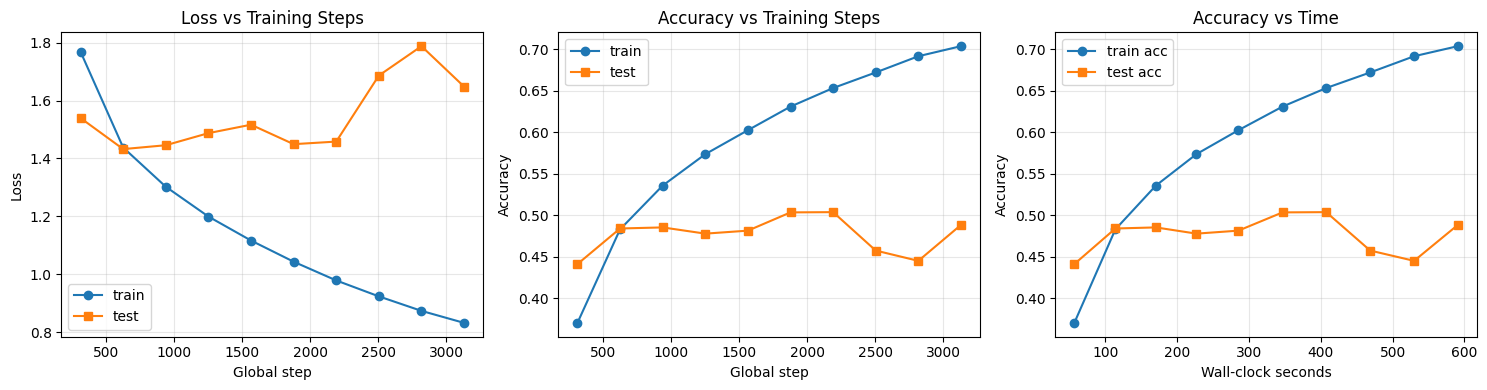

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import math

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss vs Global Step
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train", marker='o')
axes[0].plot(hist_df["global_step"], hist_df["test_loss"], label="test", marker='s')
axes[0].set_xlabel("Global step")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Training Steps")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy vs Global Step
axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train", marker='o')
axes[1].plot(hist_df["global_step"], hist_df["test_acc"], label="test", marker='s')
axes[1].set_xlabel("Global step")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs Training Steps")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Accuracy vs Wall-clock Time
axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc", marker='o')
axes[2].plot(hist_df["cumulative_sec"], hist_df["test_acc"], label="test acc", marker='s')
axes[2].set_xlabel("Wall-clock seconds")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Accuracy vs Time")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




---


# Section 4: Optimizers
Here we plan to run a few other optimizers to test how well it fairs up to Adam on its own.
Specifically, we plan to build the following optimizers:
- AdamW
- RMSProp
- Adagrad
- LAMB
- AdaBelief

# AdamW

In [ ]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()

('adam', 'adamw', 'rmsprop', 'sgd')

In [ ]:
# Place Holder --- Change the config and re-run
adamW_config = {
    "optimizer": {
        "name": "adamw",
        "lr": 1e-3,
        "weight_decay": 5e-4,
    },
    "run": {
        "epochs": 10,
        "seed": 42,
        "max_batches": 20,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

In [ ]:
# Option 2 ------------------------ using log_and_evaluate_epoch
# Initialize tracking lists
history = []
val_metrics = []

# Create validation loader
model = build_cifar10_model(device=runtime_device)
train_loader = build_cifar10_train_loader(batch_size=128, shuffle=False, device=runtime_device)

# Create the callback (using a lambda or partial to capture the lists)
from functools import partial

metrics_callback = partial(
    log_and_evaluate_epoch,
    history=history,
    val_metrics=val_metrics,
    model=model,
    val_loader=train_loader
)

# Train with the combined callback
final_acc, final_loss, training_history = train_cifar10(
    model,
    train_loader,
    optimizer=None,
    loss_fn=nn.SoftmaxLoss,
    config=adamW_config,
    metrics_callback=metrics_callback,
)
print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 4.12s
Epoch 01 done | Train Acc 19.73% | Train Loss 2.4260 | LR 0.001000 | Duration 4.12s
           | Val Acc 18.10% | Val Loss 2.2265
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 3.58s
Epoch 02 done | Train Acc 41.48% | Train Loss 1.6633 | LR 0.001000 | Duration 3.58s
           | Val Acc 28.44% | Val Loss 1.9619
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.56s
Epoch 03 done | Train Acc 60.74% | Train Loss 1.2494 | LR 0.001000 | Duration 3.56s
           | Val Acc 30.66% | Val Loss 1.9646
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 3.58s
Epoch 04 done | Train Acc 75.23% | Train Loss 0.9196 | LR 0.001000 | Duration 3.58s
           | Val Acc 31.46% | Val Loss 2.0304
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 3.54s
Epoch 05 done | Train Acc 82.62% | Train Loss 0.7021 | LR 0.001000 | Duration 3.54s
           | Val Acc 32.12% | Val Loss 2.1334
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 3.95s
Epoch 06 done | Train Acc 87.54% | Train Loss 0.5624 | LR 0.001000 | Duration 3.95s
           | Val Acc 30.89% | Val Loss 2.3590
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.52s
Epoch 07 done | Train Acc 90.08% | Train Loss 0.4328 | LR 0.001000 | Duration 3.52s
           | Val Acc 29.49% | Val Loss 2.6200
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.53s
Epoch 08 done | Train Acc 92.89% | Train Loss 0.3123 | LR 0.001000 | Duration 3.53s
           | Val Acc 30.99% | Val Loss 2.6646
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 3.49s
Epoch 09 done | Train Acc 96.33% | Train Loss 0.1926 | LR 0.001000 | Duration 3.49s
           | Val Acc 29.92% | Val Loss 2.8212
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.73s
Epoch 10 done | Train Acc 98.55% | Train Loss 0.0962 | LR 0.001000 | Duration 3.73s
           | Val Acc 32.43% | Val Loss 2.8973

Final training metrics -> Acc: 98.55% | Loss: 0.0962


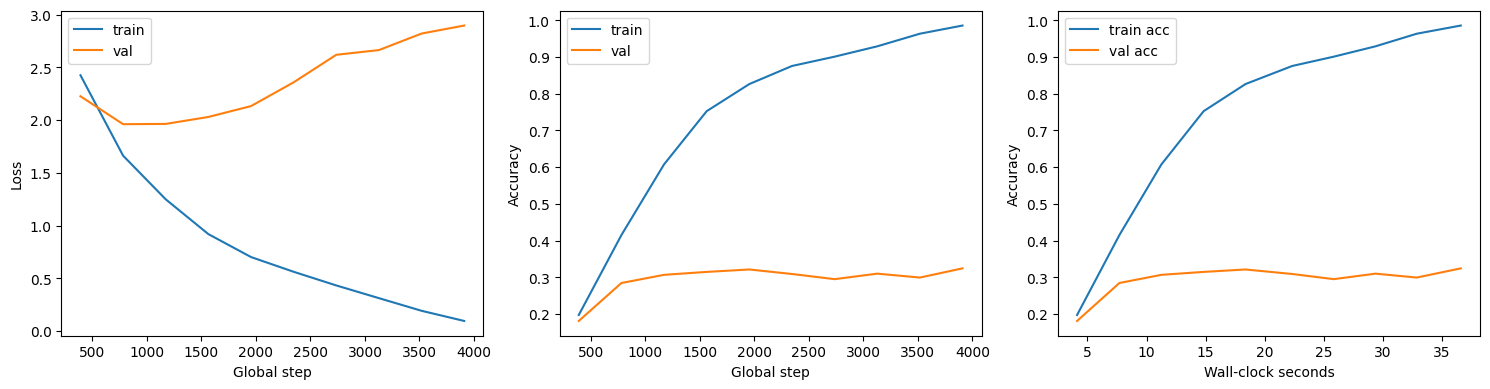

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train")
axes[0].plot(hist_df["global_step"], hist_df["val_loss"], label="val")
axes[0].set_xlabel("Global step"); axes[0].set_ylabel("Loss"); axes[0].legend()

axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train")
axes[1].plot(hist_df["global_step"], hist_df["val_acc"], label="val")
axes[1].set_xlabel("Global step"); axes[1].set_ylabel("Accuracy"); axes[1].legend()

axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc")
axes[2].plot(hist_df["cumulative_sec"], hist_df["val_acc"], label="val acc")
axes[2].set_xlabel("Wall-clock seconds"); axes[2].set_ylabel("Accuracy"); axes[2].legend()

plt.tight_layout()

# RMSProp

In [ ]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()

('adam', 'rmsprop', 'sgd')

In [ ]:
# Place Holder --- Change the config and re-run
rmsprop_config = {
    "optimizer": {
        "name": "rmsprop",
        "lr": 1e-3,
        "weight_decay": 5e-4,
    },
    "run": {
        "epochs": 10,
        "seed": 42,
        "max_batches": 20,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

In [ ]:
# Option 2 ------------------------ using log_and_evaluate_epoch
# Initialize tracking lists
history = []
val_metrics = []

# Create validation loader
model = build_cifar10_model(device=runtime_device)
train_loader = build_cifar10_train_loader(batch_size=128, shuffle=False, device=runtime_device)

# Create the callback (using a lambda or partial to capture the lists)
from functools import partial

metrics_callback = partial(
    log_and_evaluate_epoch,
    history=history,
    val_metrics=val_metrics,
    model=model,
    val_loader=train_loader
)

# Train with the combined callback
final_acc, final_loss, training_history = train_cifar10(
    model,
    train_loader,
    optimizer=None,
    loss_fn=nn.SoftmaxLoss,
    config=rmsprop_config,
    metrics_callback=metrics_callback,
)
print("\nFinal training metrics -> Acc: {:.2f}% | Loss: {:.4f}".format(final_acc * 100, final_loss))

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 68.74s
Epoch 01 done | Train Acc 23.83% | Train Loss 2.3373 | LR 0.001000 | Duration 68.74s
           | Val Acc 22.88% | Val Loss 2.0576
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 68.00s
Epoch 02 done | Train Acc 40.55% | Train Loss 1.6290 | LR 0.001000 | Duration 68.00s
           | Val Acc 31.34% | Val Loss 1.9194
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 69.44s
Epoch 03 done | Train Acc 54.34% | Train Loss 1.2944 | LR 0.001000 | Duration 69.44s
           | Val Acc 33.50% | Val Loss 1.8936
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 67.63s
Epoch 04 done | Train Acc 67.58% | Train Loss 0.9986 | LR 0.001000 | Duration 67.63s
           | Val Acc 34.77% | Val Loss 2.0075
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 68.44s
Epoch 05 done | Train Acc 78.67% | Train Loss 0.7263 | LR 0.001000 | Duration 68.44s
           | Val Acc 35.11% | Val Loss 2.0359
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 68.35s
Epoch 06 done | Train Acc 85.74% | Train Loss 0.5165 | LR 0.001000 | Duration 68.35s
           | Val Acc 34.07% | Val Loss 2.3859
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 68.00s
Epoch 07 done | Train Acc 93.32% | Train Loss 0.3127 | LR 0.001000 | Duration 68.00s
           | Val Acc 35.74% | Val Loss 2.3937
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 67.55s
Epoch 08 done | Train Acc 97.38% | Train Loss 0.1740 | LR 0.001000 | Duration 67.55s
           | Val Acc 36.93% | Val Loss 2.5184
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 67.46s
Epoch 09 done | Train Acc 99.22% | Train Loss 0.0880 | LR 0.001000 | Duration 67.46s
           | Val Acc 36.96% | Val Loss 2.6378
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 67.47s
Epoch 10 done | Train Acc 99.57% | Train Loss 0.0484 | LR 0.001000 | Duration 67.47s
           | Val Acc 36.79% | Val Loss 2.7914

Final training metrics -> Acc: 99.57% | Loss: 0.0484


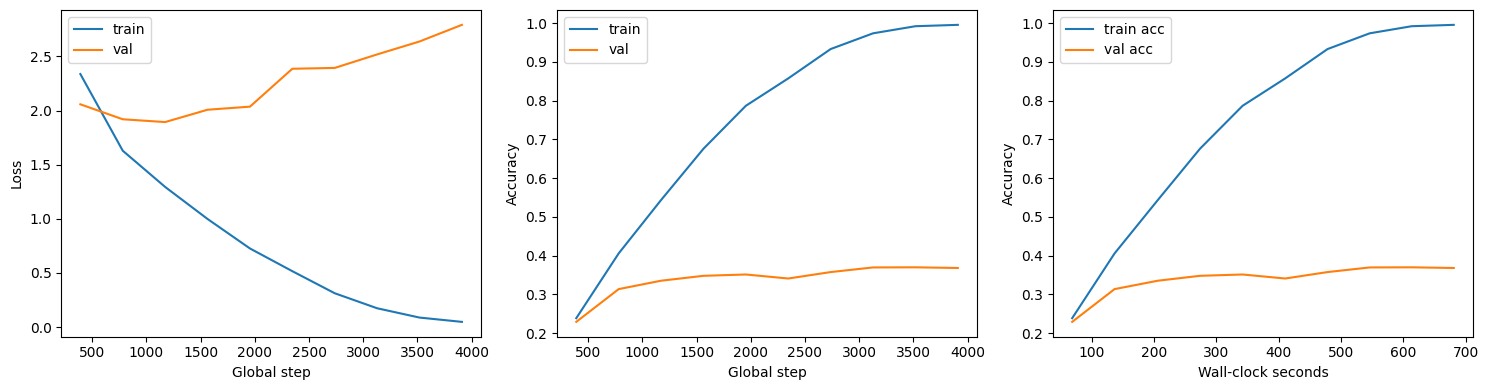

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train")
axes[0].plot(hist_df["global_step"], hist_df["val_loss"], label="val")
axes[0].set_xlabel("Global step"); axes[0].set_ylabel("Loss"); axes[0].legend()

axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train")
axes[1].plot(hist_df["global_step"], hist_df["val_acc"], label="val")
axes[1].set_xlabel("Global step"); axes[1].set_ylabel("Accuracy"); axes[1].legend()

axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc")
axes[2].plot(hist_df["cumulative_sec"], hist_df["val_acc"], label="val acc")
axes[2].set_xlabel("Wall-clock seconds"); axes[2].set_ylabel("Accuracy"); axes[2].legend()

plt.tight_layout()

# Adagrad

In [ ]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()

In [ ]:
# Place Holder --- Change the config and re-run
adagrad_config = {
    "optimizer": {
        "name": "adagrad",
        "lr": 1e-3,
        "weight_decay": 5e-4,
    },
    "run": {
        "epochs": 1,
        "seed": 42,
        "max_batches": 20,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

# LAMB

In [ ]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()

In [ ]:
# Place Holder --- Change the config and re-run
lamb_config = {
    "optimizer": {
        "name": "lamb",
        "lr": 1e-3,
        "weight_decay": 5e-4,
    },
    "run": {
        "epochs": 1,
        "seed": 42,
        "max_batches": 20,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

# AdaBelief

In [ ]:
import importlib
import needle.optim as optim

importlib.reload(optim)        # or just restart the kernel
optim.available_optimizers()

In [ ]:
# Place Holder --- Change the config and re-run
adabelief_config = {
    "optimizer": {
        "name": "adabelief",
        "lr": 1e-3,
        "weight_decay": 5e-4,
    },
    "run": {
        "epochs": 1,
        "seed": 42,
        "max_batches": 20,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}



---


# Section 5: Final Thoughts from Above Experiments
Placeholder



---


# --------- End of Final Project ------------
## ---------- Misc. Experiments --------------
These are experiments that we will leave as placeholders for the purpose of testing. And none of these experiments will contribute to our final report.

Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/2] starting (128 batches cap)...


Epoch 1/2:   0%|          | 0/128 [00:00<?, ?it/s]

[Epoch 1/2] finished in 388.61s
[Epoch 2/2] starting (128 batches cap)...


Epoch 2/2:   0%|          | 0/128 [00:00<?, ?it/s]

[Epoch 2/2] finished in 387.89s


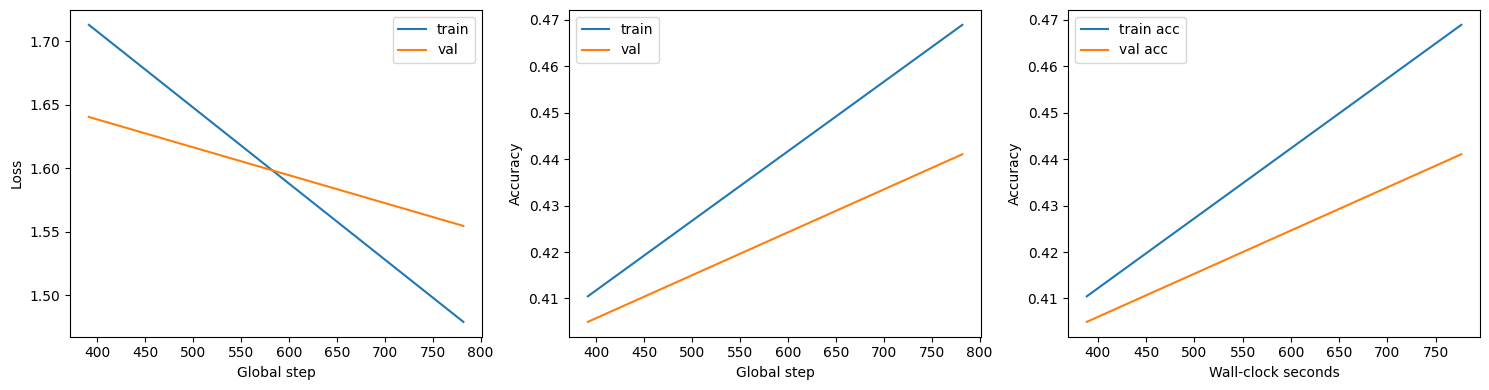

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from apps.simple_ml import evaluate_cifar10
import math

adam_config = {
    "optimizer": {
        "name": "adam",
        "lr": 1e-3,
        "weight_decay": 5e-4,
    },
    "run": {
        "epochs": 2,
        "seed": 42,
        "max_batches": 128,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

history = []

val_loader = build_cifar10_train_loader(  # reuse helper but switch to eval data
    batch_size=128,
    shuffle=False,
    device=runtime_device,
)
val_loader.dataset.train = False  # assumes CIFAR10Dataset(train=...) flag

val_metrics = []

def capture_epoch(metrics):
    history.append(metrics)
    val_acc, val_loss = evaluate_cifar10(model, val_loader)
    metrics["val_acc"] = val_acc
    metrics["val_loss"] = val_loss
    val_metrics.append({"epoch": metrics["epoch"], "val_acc": val_acc, "val_loss": val_loss})

final_acc, final_loss, history = train_cifar10(
    model,
    train_loader,
    optimizer=ndl.optim.Adam,
    loss_fn=nn.SoftmaxLoss,
    config=adam_config,
    metrics_callback=capture_epoch,
)

steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
hist_df = pd.DataFrame(history)
hist_df["global_step"] = hist_df["epoch"] * steps_per_epoch
hist_df["cumulative_sec"] = hist_df["duration_sec"].cumsum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(hist_df["global_step"], hist_df["train_loss"], label="train")
axes[0].plot(hist_df["global_step"], hist_df["val_loss"], label="val")
axes[0].set_xlabel("Global step"); axes[0].set_ylabel("Loss"); axes[0].legend()

axes[1].plot(hist_df["global_step"], hist_df["train_acc"], label="train")
axes[1].plot(hist_df["global_step"], hist_df["val_acc"], label="val")
axes[1].set_xlabel("Global step"); axes[1].set_ylabel("Accuracy"); axes[1].legend()

axes[2].plot(hist_df["cumulative_sec"], hist_df["train_acc"], label="train acc")
axes[2].plot(hist_df["cumulative_sec"], hist_df["val_acc"], label="val acc")
axes[2].set_xlabel("Wall-clock seconds"); axes[2].set_ylabel("Accuracy"); axes[2].legend()

plt.tight_layout()

### Hyperparameter Sweep Example
This example shows how to sweep over optimizer settings using the grid utilities. Adjust the sweep specification or builders to match your experiments.


In [ ]:
from apps.simple_ml import run_cifar10_grid_search

print(use_cuda)

# Base configuration shared by all runs
grid_base_config = {
    "optimizer": {
        "name": "adamw",
        "lr": 1e-3,
        "weight_decay": 0.0,
    },
    "run": {
        "epochs": 10,
        "seed": 123,
        "max_batches": 20,  # limit workload for quick tests
        "verbose": True,
        "device": "cuda" if use_cuda else "cpu",
    },
    "loss": {
        "name": "SoftmaxLoss",
    },
    "return_history": True,
    "progress_bar": True,
}

# Sweep specification: try multiple learning rates and beta1 values
grid_sweep_spec = {
    "optimizer.lr": [1e-3, 5e-4],
    "optimizer.hyperparams.beta1": [0.9, 0.95],
}

# Reuse builders from previous cell if available, otherwise define light fallbacks
try:
    build_cifar10_model
    build_cifar10_train_loader
except NameError:
    def build_cifar10_model(device=None, dtype="float32"):
        device = device or ndl.cpu()
        return ResNet9(device=device, dtype=dtype)

    def build_cifar10_train_loader(batch_size=128, shuffle=True):
        dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
        return ndl.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Execute the sweep (each run returns history thanks to merge_run_config)
sweep_results = run_cifar10_grid_search(
    model_builder=lambda: build_cifar10_model(device=ndl.cuda()),
    dataloader_builder=lambda: build_cifar10_train_loader(batch_size=128, shuffle=True, device=ndl.cuda()),
    base_config=grid_base_config,
    sweep_spec=grid_sweep_spec,
)

# Display summary
def summarize_runs(results):
    lines = []
    for result in results:
        cfg = result["config"]
        opt_cfg = cfg.get("optimizer", {})
        lr = opt_cfg.get("lr")
        beta1 = opt_cfg.get("hyperparams", {}).get("beta1")
        final_acc = result["final_acc"] * 100
        final_loss = result["final_loss"]
        lines.append(
            f"Run {result['run_id']:02d}: lr={lr:.5f}, beta1={beta1:.2f} -> Acc {final_acc:.2f}% | Loss {final_loss:.4f}"
        )
    return "\n".join(lines)

print("Adam sweep (learning rate vs beta1):")
print(summarize_runs(sweep_results))


True
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.63s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 3.52s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.58s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 4.13s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 3.43s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 3.55s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.85s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.68s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 3.54s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.55s
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.90s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 3.58s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.54s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 4.44s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 3.72s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 3.54s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.61s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.89s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 3.61s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.57s
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.64s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 3.95s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.69s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 3.49s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 4.08s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 3.67s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.47s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.71s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 4.00s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.43s
Found CIFAR-10 data at: ./data/cifar-10-batches-py
Created DataLoader with 50000 samples, batch_size=128
[Epoch 1/10] starting (20 batches cap)...


Epoch 1/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/10] finished in 3.61s
[Epoch 2/10] starting (20 batches cap)...


Epoch 2/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 2/10] finished in 4.00s
[Epoch 3/10] starting (20 batches cap)...


Epoch 3/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 3/10] finished in 3.57s
[Epoch 4/10] starting (20 batches cap)...


Epoch 4/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 4/10] finished in 3.55s
[Epoch 5/10] starting (20 batches cap)...


Epoch 5/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 5/10] finished in 3.65s
[Epoch 6/10] starting (20 batches cap)...


Epoch 6/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 6/10] finished in 4.03s
[Epoch 7/10] starting (20 batches cap)...


Epoch 7/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 7/10] finished in 3.57s
[Epoch 8/10] starting (20 batches cap)...


Epoch 8/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 8/10] finished in 3.55s
[Epoch 9/10] starting (20 batches cap)...


Epoch 9/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 9/10] finished in 4.10s
[Epoch 10/10] starting (20 batches cap)...


Epoch 10/10:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10/10] finished in 3.82s
Adam sweep (learning rate vs beta1):
Run 01: lr=0.00100, beta1=0.90 -> Acc 99.34% | Loss 0.0807
Run 02: lr=0.00100, beta1=0.95 -> Acc 99.80% | Loss 0.0541
Run 03: lr=0.00050, beta1=0.90 -> Acc 98.91% | Loss 0.2000
Run 04: lr=0.00050, beta1=0.95 -> Acc 99.22% | Loss 0.2057


In [ ]:
import sys
sys.path.append('./python')
sys.path.append('./apps')
import needle as ndl
from models import ResNet9
from simple_ml import train_cifar10, evaluate_cifar10
def to_device(loader, device):
      for X, y in loader:
          yield (
              ndl.Tensor(X.numpy(), device=device),
              ndl.Tensor(y.numpy(), device=device),
          )
device = ndl.cuda()
if not device.enabled():
    device = ndl.cpu()
dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
base_loader = ndl.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

train_loader = to_device(base_loader, device)

model = ResNet9(device=device, dtype="float32")
train_cifar10(model, train_loader, n_epochs=10, optimizer=ndl.optim.Adam, lr=0.001, weight_decay=0.001)
# dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
# dataloader = ndl.data.DataLoader(\
#          dataset=dataset,
#          batch_size=128,
#          shuffle=True,)
# model = ResNet9(device=device, dtype="float32")
# train_cifar10(model, dataloader, n_epochs=10, optimizer=ndl.optim.Adam,
#       lr=0.001, weight_decay=0.001)
evaluate_cifar10(model, base_loader)

TypeError: matmul(): incompatible function arguments. The following argument types are supported:
    1. (arg0: needle.backend_ndarray.ndarray_backend_cuda.Array, arg1: needle.backend_ndarray.ndarray_backend_cuda.Array, arg2: needle.backend_ndarray.ndarray_backend_cuda.Array, arg3: typing.SupportsInt, arg4: typing.SupportsInt, arg5: typing.SupportsInt) -> None

Invoked with: <needle.backend_ndarray.ndarray_backend_cuda.Array object at 0x7e90c90da730>, <needle.backend_ndarray.ndarray_backend_cpu.Array object at 0x7e90c81697b0>, <needle.backend_ndarray.ndarray_backend_cuda.Array object at 0x7e90c8723c30>, 8192, 147, 16

# ----- Previous Homework 4 Implementation for Reference ----

## Part 1: ND Backend [10 pts]

Recall that in homework 2, the `array_api` was imported as `numpy`. In this part, the goal is to write the necessary operations with `array_api` imported from the needle backend `NDArray` in `python/needle/backend_ndarray/ndarray.py`. Make sure to copy the solutions for `reshape`, `permute`, `broadcast_to` and `__getitem__` from homework 3.

Fill in the following classes in `python/needle/ops/ops_logarithmic.py` and `python/needle/ops/ops_mathematic.py`:

- `PowerScalar`
- `EWiseDiv`
- `DivScalar`
- `Transpose`
- `Reshape`
- `BroadcastTo`
- `Summation`
- `MatMul`
- `Negate`
- `Log`
- `Exp`
- `ReLU`
- `LogSumExp`
- `Tanh` (new)
- `Stack` (new)
- `Split` (new)

Note that for most of these, you already wrote the solutions in the previous homework and you should not change most part of your previous solution, if issues arise, please check if the `array_api` function used is supported in the needle backend.

The `Tanh`, `Stack`, and `Split` operators are newly added. `Stack` concatenates same-sized tensors along a new axis, and `Split` undoes this operation. The gradients of the two operations can be written in terms of each other. We do not directly test `Split`, and only test the backward pass of `Stack` (for which we assume you used `Split`).

**Note:** You may want to make your Summation op support sums over multiple axes; you will likely need it for the backward pass of the BroadcastTo op if yours supports broadcasting over multiple axes at a time. However, this is more about ease of use than necessity, and we leave this decision up to you (there are no corresponding tests).

**Note:** Depending on your implementations, you may want to ensure that you call `.compact()` before reshaping arrays. (If this is necessary, you will run into corresponding error messages later in the assignment.)

**Note**: Be careful not to accidentally delete or modify any new imports and function declarations when copying over code from previous assignments.

In [ ]:
!python3 -m pytest -l -v -k "nd_backend"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1685 deselected / 118 selected                          

tests/hw4/test_nd_backend.py::test_ewise_fn[cpu-shape0-divide] PASSED    [  0%]
tests/hw4/test_nd_backend.py::test_ewise_fn[cpu-shape0-subtract] PASSED  [  1%]
tests/hw4/test_nd_backend.py::test_ewise_fn[cpu-shape1-divide] PASSED    [  2%]
tests/hw4/test_nd_backend.py::test_ewise_fn[cpu-shape1-subtract] PASSED  [  3%]
tests/hw4/test_nd_backend.py::test_ewise_fn[cuda-shape0-divide] PASSED   [  4%]
tests/hw4/test_nd_backend.py::test_ewise_fn[cuda-shape0-subtract] PASSED [  5%]
tests/hw4/test_nd_backend.py::test_ewise_fn[cuda-shape1-divide] PASSED   [  5%]
tests/hw4/test_nd_backend.py::test_ewise_fn[cuda-shape1-subtract] PASSED [

In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "new_nd_backend"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.38
collecting ... Using needle backend
collected 10 items / 9 deselected / 1 selected                                 

tests/hw4/test_nd_backend.py 
Submitting new_nd_backend...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
Grader test 12 passed
Grader test 13 passed
Grader test 14 passed
Grader test 15 passed
Grader test 16 passed
Grader test 17 passed
Grader test 18 passed
Grader test 19 passed
Grader test 20 passed
Grader test 21 passed
Grader test 22 passed
Grader test 23 passed
Grader test 24 passed
Grader test 25 passed
Grader test 26 passed
Grader test 2

## Part 2: CIFAR-10 dataset [10 points]

Next, you will write support for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image classification dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50k training images and 10k test images.

Start by implementing the `__init__` function in the `CIFAR10Dataset` class in `python/needle/data/datasets/cifar10_dataset.py`. You can read in the link above how to properly read the CIFAR-10 dataset files you downloaded at the beginning of the homework. Also fill in `__getitem__` and `__len__`. Note that the return shape of the data from `__getitem__` should be in order (3, 32, 32).

Copy `python/needle/data/data_transforms.py` and `python/needle/data/data_basic.py` from previous homeworks.

In [ ]:
!python3 -m pytest -l -v -k "test_cifar10"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1793 deselected / 10 selected                           

tests/hw4/test_cifar_ptb_data.py::test_cifar10_dataset[True] PASSED      [ 10%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_dataset[False] PASSED     [ 20%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-True-1] PASSED [ 30%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-True-15] PASSED [ 40%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-False-1] PASSED [ 50%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-False-15] PASSED [ 60%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cuda-True-1] PASSED [ 70%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cuda-True-15] P

In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "cifar10"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.38
collecting ... Using needle backend
collected 10 items / 9 deselected / 1 selected                                 

tests/hw4/test_cifar_ptb_data.py 
Submitting cifar10...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
Grader test 12 passed
Grader test 13 passed
Grader test 14 passed
Grader test 15 passed
Grader test 16 passed
Grader test 17 passed
Grader test 18 passed
.

======================= 1 passed, 9 deselected in 7.42s ========================


## Part 3: Convolutional neural network [40 points]

Here's an outline of what you will do in this task.

In `python/needle/backend_ndarray/ndarray.py`, implement:
- `flip`
- `pad`

In `python/needle/ops/ops_mathematic.py`, implement (forward and backward):
- `Flip`
- `Dilate`
- `UnDilate`
- `Conv`

In `python/needle/nn/nn_conv.py`, implement:
- `Conv`

In `apps/models.py`, fill in the `ResNet9` class.  

In `apps/simple_ml.py`, fill in:
- `epoch_general_cifar10`,
- `train_cifar10`
- `evaluate_cifar10`

We have provided a `BatchNorm2d` implementation in `python/needle/nn/nn_basic.py` for you as a wrapper around your previous `BatchNorm1d` implementation.

**Note**: Remember to copy the solution of `nn_basic.py` from previous homework, make sure to not overwrite the `BatchNorm2d` module.

### Padding ndarrays

Convolution as typically implemented in deep learning libraries cuts down the size of inputs;
e.g., a (1, 32, 32, 3) image convolved with a 3x3 filter would give a (1, 30, 30, c) output.
A way around this is to pad the input ndarray before performing convolution, e.g., pad with zeros to get a (1, 34, 34, 3) ndarray so that the result is (1, 32, 32, 3).

Padding is also required for the backward pass of convolution.

You should implement `pad` in `ndarray.py` to closely reflect the behavior of `np.pad`.
That is, `pad` should take a tuple of 2-tuples with length equal to the number of dimensions of the array,
where each element in the 2-tuple corresponds to "left padding" and "right padding", respectively.

For example, if `A` is a (10, 32, 32, 8) ndarray (think NHWC), then `A.pad( (0, 0), (2, 2), (2, 2), (0, 0) )` would be a (10, 36, 36, 8) ndarray where the "spatial" dimension has been padded by two zeros on all sides.

In [ ]:
!python3 -m pytest -l -v -k "pad_forward"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1801 deselected / 2 selected                            

tests/hw4/test_conv.py::test_pad_forward[params0-needle.backend_ndarray.ndarray_backend_cpu] PASSED [ 50%]
tests/hw4/test_conv.py::test_pad_forward[params1-needle.backend_ndarray.ndarray_backend_cpu] PASSED [100%]

====================== 2 passed, 1801 deselected in 2.17s ======================


-------------------------------------

### Flipping ndarrays & FlipOp

In [ ]:
import numpy as np
import ctypes

Some utility code for a demonstration below which you can probably ignore. It might be instructive to check out the `offset` function.

In [ ]:
# reads off the underlying data array in order (i.e., offset 0, offset 1, ..., offset n)
# i.e., ignoring strides
def raw_data(X):
    X = np.array(X) # copy, thus compact X
    return np.frombuffer(ctypes.string_at(X.ctypes.data, X.nbytes), dtype=X.dtype, count=X.size)

# Xold and Xnew should reference the same underlying data
def offset(Xold, Xnew):
    assert Xold.itemsize == Xnew.itemsize
    # compare addresses to the beginning of the arrays
    return (Xnew.ctypes.data - Xold.ctypes.data)//Xnew.itemsize

def strides(X):
    return ', '.join([str(x//X.itemsize) for x in X.strides])

def format_array(X, shape):
    assert len(shape) == 3, "I only made this formatting work for ndims = 3"
    def chunks(l, n):
        n = max(1, n)
        return (l[i:i+n] for i in range(0, len(l), n))
    a = [str(x) if x >= 10 else ' ' + str(x) for x in X]
    a = ['(' + ' '.join(y) + ')' for y in [x for x in chunks(a, shape[-1])]]
    a = ['|' + ' '.join(y) + '|' for y in [x for x in chunks(a, shape[-2])]]
    return '  '.join(a)

def inspect_array(X, *, is_a_copy_of):
    # compacts X, then reads it off in order
    print('Data: %s' % format_array(raw_data(X), X.shape))
    # compares address of X to copy_of, thus finding X's offset
    print('Offset: %s' % offset(is_a_copy_of, X))
    print('Strides: %s' % strides(X))

In order to implement the backwards pass of 2D convolution, we will (probably) need a function which _flips_
axes of ndarrays. We say "probably" because you could probably cleverly implement your convolution forward
function to avoid this. However, we think it is easiest to think about this if you have the ability to "flip" the kernel along its vertical and horizontal dimensions.

We will try to build up your intuition for the "flip" operation below in order to help you figure out how to implement it in `ndarray.py`. To do that, we explore numpy's `np.flip` function below. One thing to note is that
`flip` is typically implemented by using negative strides and changing the _offset_ of the underlying array.

For example, flipping an array on _all_ of its axes is equivalent to reversing the array. In this case, you can imagine that we would want all the strides to be negative, and the offset to be the length of the array (to start at the end of the array and "stride" backwards).

Since we did not explicitly support negative strides in our implementation for the last homework, we will merely call `NDArray.make` with them to make our "flipped" array and then immediately call `.compact()`. Other than changing unsigned ints to signed ints in a few places, we suspect your existing `compact` function should not have to change at all to accomodate negative strides. In the .cc and .cu files we distributed, we have already changed the function signatures to reflect this.

Alternatively, you could simply implement `flip` in the CPU backend by copying memory, which you _may_ find more intuitive. We suggest following our mini tutorial below to keep your implementation Python-focused, since we believe it is involves approximately the same amount of effort to implement it slightly more naively in C.

Use this array as reference for the other examples:

In [ ]:
A = np.arange(1, 25).reshape(3, 2, 4)
inspect_array(A, is_a_copy_of=A)

We have put brackets around each axis of the array. Notice that for this array, the offset is 0 and the strides are all positive.

----------------------------------------------------------

See what happens when you flip the array along the last axis below.
Note that the `inspect_array` function compacts the array after flipping it so you can see the
"logical" order of the data, and the offset is calculated by comparing the address of the **non**-compacted
flipped array with that of `is_copy_of`, i.e., the array `A` we looked at above.

That is, we are looking at how numpy calculates the strides and offset for flipped arrays in order
to copy this behavior in our own implementation.

In [ ]:
inspect_array(np.flip(A, (2,)), is_a_copy_of=A)

So flipping the last axis reverses the order of the elements within each 4-dimensional "cell", as you can see above. The stride corresponding to the axis we flipped has been negated. And the offset is 3 -- this makes sense, e.g., because we want the new "first" element of the array to be 4, which was at index 3 in `A`.

In [ ]:
inspect_array(np.flip(A, (1,)), is_a_copy_of=A)

Again for the middle axis: we negate the middle stride, and the offset is 4, which seems reasonable since we now want the first element to be 5, which was at index 4 in the original array `A`.

In [ ]:
inspect_array(np.flip(A, (0,)), is_a_copy_of=A)

Try to infer the more general algorithm for computing the offset given the axis to flip.

----------------------------------------------------------------------------------------------------------

Observe what happens when we flip _all_ axes.

In [ ]:
inspect_array(np.flip(A, (0, 1, 2)), is_a_copy_of=A)

As mentioned earlier, the offset is then sufficient to point to the last element of the array, and this is just the "reverse order" version of `A`.

When we flip just axes 1 and 0...

In [ ]:
inspect_array(np.flip(A, (0, 1)), is_a_copy_of=A)

The offset is 20. Looking back on our previous offset computations, do you notice something?

-------------------

With this exploration of numpy's ndarray flipping functionality, which uses negative strides and a custom offset,
try to implement `flip` in `ndarray.py`. You also must implement "flip" forward and backward functions in `ops_mathematic.py`; note that these should be extremely short.

**Important:** You should call NDArray.make with the new strides and offset, and then immediately `.compact()` this array. The resulting array is then copied and has positive strides. We want this (less-than-optimal) behavior because we did not account for negative strides in our previous implementation. _Aside:_ If you want, consider where/if negative strides break your implementation. `__getitem__` definitely doesn't work due to how we processed slices; is there anything else? (_Note_: this isn't graded.)

Also, if you want to add a `flip` operator implementation on the CPU/CUDA backends instead, that's also okay.



In [ ]:
!python3 -m pytest -l -v -k "flip"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1763 deselected / 40 selected                           

tests/hw4/test_conv.py::test_flip_forward[params0-needle.backend_ndarray.ndarray_backend_cpu] PASSED [  2%]
tests/hw4/test_conv.py::test_flip_forward[params0-needle.backend_ndarray.ndarray_backend_cuda] PASSED [  5%]
tests/hw4/test_conv.py::test_flip_forward[params1-needle.backend_ndarray.ndarray_backend_cpu] PASSED [  7%]
tests/hw4/test_conv.py::test_flip_forward[params1-needle.backend_ndarray.ndarray_backend_cuda] PASSED [ 10%]
tests/hw4/test_conv.py::test_flip_forward[params2-needle.backend_ndarray.ndarray_backend_cpu] PASSED [ 12%]
tests/hw4/test_conv.py::test_flip_forward[params2-needle.backend_ndarray.ndarray_backend_cud

-------------------------------------

### Dilation


The dilation operator puts zeros between elements of an ndarray. We will need it for computing the backward pass of convolution when the stride of the convolution is greater than 1. As an example, dilation should do the following to a 2x2 matrix when dilated by 1 on both axes:

$$
\begin{bmatrix}
1 & 2 \\
3 & 4
\end{bmatrix}
\Longrightarrow
\begin{bmatrix}
1 & 0 & 2 & 0 \\
0 & 0 & 0 & 0 \\
3 & 0 & 4 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$

To get some intuition for why we need dilation for the backward pass of strided convolution, consider a  `stride=2`, `padding="same"`, `input_channels=output_channels=8` convolution applied to an input of size (10, 32, 32, 8). The resulting output will be of size (10, 16, 16, 8) due to the stride, and thus `out_grad` will have shape (10, 16, 16, 8). Yet, the gradient of the input needs to, of course, have shape (10, 32, 32, 8) -- so we must need to increase the size of `out_grad` in some way. Consider also that you could implement strided convolution as `Conv(x)[:, ::2, ::2, :]`, i.e., only keeping every other pixel in the spatial dimension.


Implement `Dilate` and `UnDilate` in `ops_mathematic.py`. Each operator takes two additional parameters (in attrs): the `dilation` amount and the `axes` to dilate. You must also implement the corresponding op `UnDilate`, whose forward pass will be used to implement the gradient of `Dilate`. (This is so we do not have to implement `GetItem` and `SetItem` ops, which can be highly inefficient to backprop through without additional optimizations.)

**Note**: The dilation amount is additive, not multiplicative. In the example above, a dilation of `1` implies adding one row/column of zeros between each element along each dilated axis (and one removed row/column for each undilated axis). A dilation of `0` means no change.

In [ ]:
!python3 -m pytest -l -v -k "dilate"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1777 deselected / 26 selected                           

tests/hw4/test_conv.py::test_dilate_forward[needle.backend_ndarray.ndarray_backend_cpu] PASSED [  3%]
tests/hw4/test_conv.py::test_dilate_forward[needle.backend_ndarray.ndarray_backend_cuda] PASSED [  7%]
tests/hw4/test_conv.py::test_dilate_backward[params0-needle.backend_ndarray.ndarray_backend_cpu] PASSED [ 11%]
tests/hw4/test_conv.py::test_dilate_backward[params0-needle.backend_ndarray.ndarray_backend_cuda] PASSED [ 15%]
tests/hw4/test_conv.py::test_dilate_backward[params1-needle.backend_ndarray.ndarray_backend_cpu] PASSED [ 19%]
tests/hw4/test_conv.py::test_dilate_backward[params1-needle.backend_ndarray.ndarray_backend_cud

---------------------------------------

### Submit new ops (flip/dilation) to mugrade [10 points]

In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "new_ops"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.38
collecting ... Using needle backend
collected 10 items / 9 deselected / 1 selected                                 

tests/hw4/test_conv.py 
Submitting new_ops...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
.

======================= 1 passed, 9 deselected in 4.94s ========================


-----------------

### Convolution forward

Implement the forward pass of 2D multi-channel convolution in `ops_mathematic.py`. You should probably refer to [this notebook](https://github.com/dlsyscourse/public_notebooks/blob/main/convolution_implementation.ipynb) from lecture, which implements 2D multi-channel convolution using im2col in numpy.

**Note:** Your convolution op should accept tensors in the NHWC format, as in the example above, and weights in the format (kernel_size, kernel_size, input_channels, output_channels).

However, you will need to add two additional features. Your convolution function should accept arguments for `padding` (default 0) and `stride` (default 1). For `padding`, you should simply apply your padding function to the spatial dimensions (i.e., axes 1 and 2).

Implementing strided convolution should consist of a relatively small set of changes to your plain convolution implementation.

We recommend working your way up through the full feature set: Implement convolution without stride first, ensuring you pass some of the tests below, and then add in support for stride.

In [ ]:
!python3 -m pytest -l -v -k "op_conv and forward"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1769 deselected / 34 selected                           

tests/hw4/test_conv.py::test_op_conv[forward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape0-W_shape0-1-0] PASSED [  2%]
tests/hw4/test_conv.py::test_op_conv[forward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape1-W_shape1-1-1] PASSED [  5%]
tests/hw4/test_conv.py::test_op_conv[forward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape2-W_shape2-1-2] PASSED [  8%]
tests/hw4/test_conv.py::test_op_conv[forward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape3-W_shape3-1-0] PASSED [ 11%]
tests/hw4/test_conv.py::test_op_conv[forward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape4-W_shape4-1-0] PASSED [ 14%]
tests/hw4

-----------------

### Convolution backward

Finding the gradients of 2D multi-channel convolution can be technically quite challenging (especially "rigorously"). We will try to provide some useful hints here. Basically, we encourage you to make use of the surprising fact that _whatever makes the dimensions work out is typically right_.

Ultimately, the backward pass of convolution can be done in terms of the convolution operator itself, with some clever manipulations using `flip`, `dilate`, and multiple applications of `transpose` to both the arguments and the results.

In the last section, we essentially implemented convolution as a matrix product: ignoring the various restride and reshape operations, we basically have something like `X @ W`, where `X` is the input and `W` is the weight. We also have `out_grad`, which is the same shape as `X @ W`. Now, you have already implemented the backward pass of matrix multiplication in a previous assignment, and we can use this knowledge to get some insight into the backward pass of convolution. In particular, referencing your matmul backward implementation, you may notice (heuristically speaking here):

`X.grad = out_grad @ W.transpose` \
`W.grad = X.transpose @ out_grad`

Surprisingly enough, things work out if we just assume that these are also convolutions (and now assuming that `out_grad`, `W`, and `X` are tensors amenable to 2D multi-channel convolution instead of matrices):

`X.grad = ≈conv(≈out_grad, ≈W)` \
`W.grad = ≈conv(≈X, ≈out_grad)`

In which the "≈" indicates that you need to apply some additional operators to these terms in order to get the dimensions to work out, such as permuting/transposing axes, dilating, changing the `padding=` argument to the convolution function, or permuting/transposing axes of the resulting convolution.

As we saw on the [last few slides here](https://dlsyscourse.org/slides/conv_nets.pdf) in class, the transpose of a convolution can be found by simply flipping the kernel. Since we're working in 2D instead of 1D, this means flipping the kernel both vertically and horizontally (thus why we implemented `flip`).

Summarizing some hints for both `X.grad` and `W.grad`:

`X.grad`
- The convolution of `out_grad` and `W`, with some operations applied to those
- `W` should be flipped over both the kernel dimensions
- If the convolution is strided, increase the size of `out_grad` with a corresponding dilation
- Do an example to analyze dimensions: note the shape you want for `X.grad`, and think about how you must permute/transpose the arguments and add padding to the convolution to achieve this shape
    - This padding depends on both the kernel size and the `padding` argument to the convolution

`W.grad`
- The convolution of `X` and `out_grad`, with some operations applied to those
- The gradients of `W` must be accumulated over the batches; how can you make the conv operator itself do this accumulation?
    - Consider turning batches into channels via transpose/permute
- Analyze dimensions: how can you modify `X` and `out_grad` so that the shape of their convolution matches the shape of `W`? You may need to transpose/permute the result.
    - Remember to account for the `padding` argument passed to convolution

General tips
- Deal with strided convolutions last (you should be able to just drop in `dilate` when you've passed most of the tests)
- Start with the case where `padding=0`, then consider changing `padding` arguments
- You can "permute" axes with multiple calls to `transpose`

It might also be useful to skip ahead to nn.Conv, pass the forward tests, and then use both the tests below and the nn.Conv backward tests to debug your implementation.

In [ ]:
!python3 -m pytest -l -v -k "op_conv and backward"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1769 deselected / 34 selected                           

tests/hw4/test_conv.py::test_op_conv[backward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape0-W_shape0-1-0] PASSED [  2%]
tests/hw4/test_conv.py::test_op_conv[backward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape1-W_shape1-1-1] PASSED [  5%]
tests/hw4/test_conv.py::test_op_conv[backward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape2-W_shape2-1-2] PASSED [  8%]
tests/hw4/test_conv.py::test_op_conv[backward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape3-W_shape3-1-0] PASSED [ 11%]
tests/hw4/test_conv.py::test_op_conv[backward-needle.backend_ndarray.ndarray_backend_cpu-Z_shape4-W_shape4-1-0] PASSED [ 14%]
test

-----------------

### nn.Conv

#### Fixing init._calculate_fans for convolution
Previously, we have implemented Kaiming uniform/normal initializations, where we essentially assigned `fan_in = input_size` and `fan_out = output_size`.
For convolution, this becomes somewhat more detailed, in that you should multiply both of these by the "receptive field size", which is in this case just the product of the kernel sizes -- which in our case are always going to be the same, i.e., $k\times k$ kernels.

**You will need to edit your `kaiming_uniform` in `python/needle/init/init_initializers.py`, etc. init functions to support multidimensional arrays.** In particular, it should support a new `shape` argument which is then passed to, e.g., the underlying `rand` function. Specifically, if the argument `shape` is not `None`, then ignore `fan_in` and `fan_out`, and use the value of `shape` for initializations instead.

You can test this below; though it is not _directly_ graded, it must match ours to pass the nn.Conv mugrade tests.

In [ ]:
!python3 -m pytest -l -v -k "kaiming_uniform"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1801 deselected / 2 selected                            

tests/hw4/test_conv.py::test_init_kaiming_uniform[needle.backend_ndarray.ndarray_backend_cpu] PASSED [ 50%]
tests/hw4/test_conv.py::test_init_kaiming_uniform[needle.backend_ndarray.ndarray_backend_cuda] PASSED [100%]

====================== 2 passed, 1801 deselected in 2.30s ======================


#### Implementing nn.Conv

Essentially, nn.Conv is just a wrapper of the convolution operator we previously implemented
which adds a bias term, initializes the weight and bias, and ensures that the padding is set so that the input and output dimensions are the same (in the `stride=1` case, anyways).

Importantly, nn.Conv should support NCHW format instead of NHWC format. In particular, we think this makes more sense given our current BatchNorm implementation. You can implement this by applying `transpose` twice to both the input and output.  

- Ensure nn.Conv works for `(N, C, H, W)` tensors even though we implemented the conv op for `(N, H, W, C)` tensors
- Initialize the `(k, k, i, o)` weight tensor using Kaiming uniform initialization with default settings
- Initialize the `(o,)` bias tensor using uniform initialization on the interval $\displaystyle\pm\frac{1}{\sqrt{\verb|in_channels| \times \verb|kernel_size|^2}}$
- Calculate the appropriate padding to ensure input and output dimensions are the same
- Calculate the convolution, then add the properly-broadcasted bias term if present

You can now test your nn.Conv against PyTorch's nn.Conv2d with the two PyTest calls below.

In [ ]:
!python3 -m pytest -l -v -k "nn_conv_forward"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1793 deselected / 10 selected                           

tests/hw4/test_conv.py::test_nn_conv_forward[needle.backend_ndarray.ndarray_backend_cpu-4-8-16-3-1] PASSED [ 10%]
tests/hw4/test_conv.py::test_nn_conv_forward[needle.backend_ndarray.ndarray_backend_cpu-32-8-16-3-2] PASSED [ 20%]
tests/hw4/test_conv.py::test_nn_conv_forward[needle.backend_ndarray.ndarray_backend_cpu-32-8-8-3-2] PASSED [ 30%]
tests/hw4/test_conv.py::test_nn_conv_forward[needle.backend_ndarray.ndarray_backend_cpu-32-16-8-3-1] PASSED [ 40%]
tests/hw4/test_conv.py::test_nn_conv_forward[needle.backend_ndarray.ndarray_backend_cpu-32-16-8-3-2] PASSED [ 50%]
tests/hw4/test_conv.py::test_nn_conv_forward[needle.backend_n

In [ ]:
!python3 -m pytest -l -v -k "nn_conv_backward"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1789 deselected / 14 selected                           

tests/hw4/test_conv.py::test_nn_conv_backward[needle.backend_ndarray.ndarray_backend_cpu-4-1-1-3-1] PASSED [  7%]
tests/hw4/test_conv.py::test_nn_conv_backward[needle.backend_ndarray.ndarray_backend_cpu-14-8-16-3-1] PASSED [ 14%]
tests/hw4/test_conv.py::test_nn_conv_backward[needle.backend_ndarray.ndarray_backend_cpu-14-8-16-3-2] PASSED [ 21%]
tests/hw4/test_conv.py::test_nn_conv_backward[needle.backend_ndarray.ndarray_backend_cpu-14-8-8-3-1] PASSED [ 28%]
tests/hw4/test_conv.py::test_nn_conv_backward[needle.backend_ndarray.ndarray_backend_cpu-14-8-8-3-2] PASSED [ 35%]
tests/hw4/test_conv.py::test_nn_conv_backward[needle.backe

-----------------

### Submit nn.Conv to mugrade [20 points]

In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "conv_forward"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collecting ... Using needle backend
collected 10 items / 9 deselected / 1 selected                                 

tests/hw4/test_conv.py 
Submitting conv_forward...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
Grader test 12 passed
Grader test 13 passed
Grader test 14 passed
.

======================= 1 passed, 9 deselected in 6.62s ========================


In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "conv_backward"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.38
collecting ... Using needle backend
collected 10 items / 9 deselected / 1 selected                                 

tests/hw4/test_conv.py 
Submitting conv_backward...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
Grader test 12 passed
Grader test 13 passed
Grader test 14 passed
Grader test 15 passed
Grader test 16 passed
Grader test 17 passed
Grader test 18 passed
.

======================= 1 passed, 9 deselected in 6.11s ========================


------------------------------------------------

### Implementing "ResNet9"

You will now use your convolutional layer to implement a model similar to _ResNet9_, which is known to be a reasonable model for getting good accuracy on CIFAR-10 quickly (see [here](https://github.com/davidcpage/cifar10-fast)). Our main change is that we used striding instead of pooling and divided all of the channels by 4 for the sake of performance (as our framework is not as well-optimized as industry-grade frameworks).

In the figure below, before the first linear layer, you should "flatten" the tensor. You can use the module `Flatten` in `nn_basic.py`, or you can simply use `.reshape` in the `forward()` method of your ResNet9.

Make sure that you pass the device to all modules in your model; otherwise, you will get errors about mismatched devices when trying to run with CUDA.

<center><img src="https://github.com/dlsyscourse/hw4/blob/main/ResNet9.png?raw=true" alt="ResNet9" style="width: 400px;" /></center>

We have tried to make it easier to pass the tests here than for previous assignments where you have implemented models. In particular, we are just going to make sure it has the right number of parameters and similar accuracy and loss after 1 or 2 batches of CIFAR-10.

In [ ]:
!python3 -m pytest -l -v -k "resnet9"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1801 deselected / 2 selected                            

tests/hw4/test_conv.py::test_resnet9[needle.backend_ndarray.ndarray_backend_cpu] PASSED [ 50%]
tests/hw4/test_conv.py::test_resnet9[needle.backend_ndarray.ndarray_backend_cuda] PASSED [100%]

====================== 2 passed, 1801 deselected in 2.40s ======================


Now we can train a ResNet on CIFAR10: (remember to copy the solutions in `python/needle/optim.py` from previous homeworks)

In [ ]:
!python3 -m pytest -l -v -k "train_cifar10"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1801 deselected / 2 selected                            

tests/hw4/test_conv.py::test_train_cifar10[needle.backend_ndarray.ndarray_backend_cpu] PASSED [ 50%]
tests/hw4/test_conv.py::test_train_cifar10[needle.backend_ndarray.ndarray_backend_cuda] PASSED [100%]

====================== 2 passed, 1801 deselected in 7.77s ======================


### Submit ResNet9 to mugrade [10 points]

In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "resnet9"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.38
collecting ... Using needle backend
collected 10 items / 9 deselected / 1 selected                                 

tests/hw4/test_conv.py 
Submitting resnet9...
Grader test 1 passed
Grader test 2 passed
.

======================= 1 passed, 9 deselected in 10.28s =======================


-----------------

Now, you can train your model on CIFAR-10 using the following code. Note that this is likely going to be quite slow, and also  not all that accurate due to the lack of data augmentation. You should expect it to take around 500s per epoch.

In [ ]:
import sys
sys.path.append('./python')
sys.path.append('./apps')
import needle as ndl
from models import ResNet9
from simple_ml import train_cifar10, evaluate_cifar10

device = ndl.cpu()
dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
dataloader = ndl.data.DataLoader(\
         dataset=dataset,
         batch_size=128,
         shuffle=True,)
model = ResNet9(device=device, dtype="float32")
train_cifar10(model, dataloader, n_epochs=10, optimizer=ndl.optim.Adam,
      lr=0.001, weight_decay=0.001)
evaluate_cifar10(model, dataloader)

* W1
    The function should use the step size lr,


NotImplementedError: 

## Part 4: Recurrent neural network [10 points]

**Note:** In the following sections, you may find yourself wanting to index into tensors, i.e., to use getitem or setitem. However, we have not implemented these for tensors in our library; instead, you should use `stack` and `split` operations.

In `python/needle/nn/nn_sequence.py`, implement `RNNCell`.

$h^\prime = \text{tanh}(xW_{ih} + b_{ih} + hW_{hh} + b_{hh})$. If nonlinearity is 'relu', then ReLU is used in place of tanh.

All weights and biases should be uniformly initialized on the interval $\displaystyle\pm\frac{1}{\sqrt{\verb|hidden_size|}}$.

In `python/needle/nn/nn_sequence.py`, implement `RNN`.

For each element in the input sequence, each layer computes the following function:

$h_t = \text{tanh}(x_tW_{ih} + b_{ih} + h_{(t-1)}W_{hh} + b_{hh})$

where $h_t$ is the hidden state at time $t$, $x_t$ is the input at time $t$, and $h_{(t-1)}$ is the hidden state of the previous layer at time $t-1$ or the initial hidden state at time $0$. If nonlinearity is 'relu', then ReLU is used in place of tanh.

In a multi-layer RNN, the input $x_t^{(l)}$ of the $l$-th layer ($l \ge 2$) is the hidden state $h_t^{(l-1)}$ of the previous layer.


In [ ]:
!python3 -m pytest -l -v -k "test_rnn"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1163 deselected / 640 selected                          

tests/hw4/test_sequence_models.py::test_rnn_cell[cpu-tanh-True-True-1-1-1] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_rnn_cell[cpu-tanh-True-True-1-1-15] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_rnn_cell[cpu-tanh-True-True-1-11-1] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_rnn_cell[cpu-tanh-True-True-1-11-15] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_rnn_cell[cpu-tanh-True-True-12-1-1] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_rnn_cell[cpu-tanh-True-True-12-1-15] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_rnn_cell[cpu-tanh-True-True-12-11-1] PASSED [  1%]
te

In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "rnn"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.38
collecting ... Using needle backend
collected 10 items / 9 deselected / 1 selected                                 

tests/hw4/test_sequence_models.py 
Submitting rnn...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
Grader test 12 passed
.

======================= 1 passed, 9 deselected in 5.10s ========================


## Part 5: Long short-term memory network [10 points]
In `python/needle/nn/nn_sequence.py`, implement `Sigmoid`.

$$\sigma(x) = \frac{1}{1 + \text{exp}(-x)}$$

In `python/needle/nn/nn_sequence.py`, implement `LSTMCell`.

\begin{align*}
i &= \sigma(xW_{ii} + b_{ii} + hW_{hi} + b_{hi}) \\
f &= \sigma(xW_{if} + b_{if} + hW_{hf} + b_{hf}) \\
g &= \text{tanh}(xW_{ig} + b_{ig} + hW_{hg} + b_{hg}) \\
o &= \sigma(xW_{io} + b_{io} + hW_{ho} + b_{ho}) \\
c^\prime &= f * c + i * g \\
h^\prime &= o * \text{tanh}(c^\prime)
\end{align*}

where $\sigma$ is the sigmoid function, and $i$, $f$, $g$, $o$ are the input, forget, cell, and output gates, respectively.

All weights and biases should be uniformly initialized on the interval $\displaystyle\pm\frac{1}{\sqrt{\verb|hidden_size|}}$.

Now implement `LSTM` in `python/needle/nn/nn_sequence.py`, which applies a multi-layer LSTM RNN to an input sequence. For each element in the input sequence, each layer computes the following function:

\begin{align*}
i_t &= \sigma(x_tW_{ii} + b_{ii} + h_{(t-1)}W_{hi} + b_{hi}) \\
f_t &= \sigma(x_tW_{if} + b_{if} + h_{(t-1)}W_{hf} + b_{hf}) \\
g_t &= \text{tanh}(x_tW_{ig} + b_{ig} + h_{(t-1)}W_{hg} + b_{hg}) \\
o_t &= \sigma(x_tW_{io} + b_{io} + h_{(t-1)}W_{ho} + b_{ho}) \\
c_t &= f * c_{(t-1)} + i * g \\
h_t &= o * \text{tanh}(c_t)
\end{align*}

where $h_t$ is the hidden state at time $t$, $c_t$ is the cell state at time $t$, $x_t$ is the input at time $t$, $h_{(t-1)}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$, and $i_t$, $f_t$, $g_t$, $o_t$ are the input, forget, cell, and output gates at time $t$ respectively.

In a multi-layer LSTM, the input $x_t^{(l)}$ of the $l$-th layer ($l \ge 2$) is the hidden state $h_t^{(l-1)}$ of the previous layer.

In [ ]:
!python3 -m pytest -l -v -k "test_lstm"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1483 deselected / 320 selected                          

tests/hw4/test_sequence_models.py::test_lstm_cell[cpu-True-True-1-1-1] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_lstm_cell[cpu-True-True-1-1-15] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_lstm_cell[cpu-True-True-1-11-1] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_lstm_cell[cpu-True-True-1-11-15] PASSED [  1%]
tests/hw4/test_sequence_models.py::test_lstm_cell[cpu-True-True-12-1-1] PASSED [  1%]
tests/hw4/test_sequence_models.py::test_lstm_cell[cpu-True-True-12-1-15] PASSED [  1%]
tests/hw4/test_sequence_models.py::test_lstm_cell[cpu-True-True-12-11-1] PASSED [  2%]
tests/hw4/test_sequence_models

In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "lstm"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, typeguard-4.4.4, langsmith-0.4.38
collecting ... Using needle backend
collected 10 items / 9 deselected / 1 selected                                 

tests/hw4/test_sequence_models.py 
Submitting lstm...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
Grader test 12 passed
Grader test 13 passed
Grader test 14 passed
Grader test 15 passed
Grader test 16 passed
.

======================= 1 passed, 9 deselected in 6.62s ========================


## Part 6: Penn Treebank dataset [10 points]

In word-level language modeling tasks, the model predicts the probability of the next word in the sequence, based on the words already observed in the sequence. You will write support for the Penn Treebank dataset, which consists of stories from the Wall Street Journal, to train and evaluate a language model on word-level prediction.

In `python/needle/data/datasets/ptb_dataset.py`, start by implementing the `Dictionary` class, which creates a dictionary from a list of words, mapping each word to a unique integer.

Next, we will use this `Dictionary` class to create a corpus from the train and test txt files in the Penn Treebank dataset that you downloaded at the beginning of the notebook. Implement the `tokenize` function in the `Corpus` class to do this.

In order to prepare the data for training and evaluation, you will next implement the `batchify` function. Starting from sequential data, batchify arranges the dataset into columns. For instance, with the alphabet as the sequence and batch size 4, we'd get

```
┌ a g m s ┐
│ b h n t │
│ c i o u │
│ d j p v │
│ e k q w │
└ f l r x ┘
```

These columns are treated as independent by the model, which means that the dependence of e. g. 'g' on 'f' cannot be learned, but allows more efficient batch processing.

Next, implement the `get_batch` function. `get_batch` subdivides the source data into chunks of length `bptt`. If source is equal to the example output of the batchify function, with a bptt-limit of 2, we'd get the following two `Tensor`s for i = 0:
```
┌ a g m s ┐ ┌ b h n t ┐
└ b h n t ┘ └ c i o u ┘
```
Note that despite the name of the function, the subdivison of data is not done along the batch dimension (i.e. dimension 1), since that was handled by the batchify function. The chunks are along dimension 0, corresponding to the seq_len dimension in the LSTM or RNN. Also, as per the function docs, the second returned `Tensor` (the targets) should be reshaped to be 1-dimensional.

In [ ]:
!python3 -m pytest -l -v -k "ptb"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1777 deselected / 26 selected                           

tests/hw4/test_cifar_ptb_data.py::test_cifar10_dataset[True] PASSED      [  3%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_dataset[False] PASSED     [  7%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-True-1] PASSED [ 11%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-True-15] PASSED [ 15%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-False-1] PASSED [ 19%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cpu-False-15] PASSED [ 23%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cuda-True-1] PASSED [ 26%]
tests/hw4/test_cifar_ptb_data.py::test_cifar10_loader[cuda-True-15] P

In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "ptb"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: langsmith-0.4.38, anyio-4.11.0, typeguard-4.4.4
collecting ... Using needle backend
collected 10 items / 8 deselected / 2 selected                                 

tests/hw4/test_cifar_ptb_data.py 
Submitting cifar10...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Error : {"status":"error","code":502,"message":"Application failed to respond","request_id":"YIYYdGGkQaGaCXSeAQeqjw"}
Grader test 12 passed
Grader test 13 passed
Grader test 14 passed
Grader test 15 passed
Grader test 16 passed
Grader test 17 passed
Grader test 18 passed
.
Submitting ptb...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4

## Part 7: Training a word-level language model [10 points]

Finally, you will use the `RNN` and `LSTM` components you have written to construct a language model that we will train on the Penn Treebank dataset.

First, in `python/needle/nn/nn_sequence.py` implement `Embedding`. Consider we have a dictionary with 1000 words. Then for a word which indexes into this dictionary, we can represent this word as a one-hot vector of size 1000, and then use a linear layer to project this to a vector of some embedding size.

In `apps/models.py`, you can now implement `LanguageModel`. Your language model should consist of

- An embedding layer (which maps word IDs to embeddings)
- A sequence model (either RNN or LSTM)
- A linear layer (which outputs probabilities of the next word)

In `apps/simple_ml.py` implement `epoch_general_ptb`, `train_ptb`, and `evaluate_ptb`.

In [ ]:
!python3 -m pytest -l -v -k "language_model_implementation"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1291 deselected / 512 selected                          

tests/hw4/test_sequence_models.py::test_language_model_implementation[cpu-rnn-1-True-1-1-1-1-1] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_language_model_implementation[cpu-rnn-1-True-1-1-1-1-13] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_language_model_implementation[cpu-rnn-1-True-1-1-1-2-1] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_language_model_implementation[cpu-rnn-1-True-1-1-1-2-13] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_language_model_implementation[cpu-rnn-1-True-1-1-15-1-1] PASSED [  0%]
tests/hw4/test_sequence_models.py::test_language_model_implementation[cpu-rnn-1-T

In [ ]:
!python3 -m pytest -l -v -k "language_model_training"

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collected 1803 items / 1801 deselected / 2 selected                            

tests/hw4/test_sequence_models.py::test_language_model_training[cpu] FAILED [ 50%]
tests/hw4/test_sequence_models.py::test_language_model_training[cuda] FAILED [100%]

=================================== FAILURES ===================================
______________________ test_language_model_training[cpu] _______________________

device = cpu()

    @pytest.mark.parametrize("device", _DEVICES, ids=["cpu", "cuda"])
    def test_language_model_training(device):
        corpus = ndl.data.Corpus("data/ptb", max_lines=20)
        seq_len = 10
        num_examples = 100
        batch_size = 16
        seq_model = 'rnn'
        num_la

In [ ]:
!python3 -m mugrade submit "$MY_API_KEY" "$HW4_NAME" -k "language_model"

submit
============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0
rootdir: /content/drive/MyDrive/10714/hw4
plugins: anyio-4.11.0, langsmith-0.4.40, typeguard-4.4.4
collecting ... Using needle backend
collected 10 items / 9 deselected / 1 selected                                 

tests/hw4/test_sequence_models.py 
Submitting language_model...
Grader test 1 passed
Grader test 2 passed
Grader test 3 passed
Grader test 4 passed
Grader test 5 passed
Grader test 6 passed
Grader test 7 passed
Grader test 8 passed
Grader test 9 passed
Grader test 10 passed
Grader test 11 passed
Grader test 12 passed
.

======================= 1 passed, 9 deselected in 6.01s ========================


Now, you can train your language model on the Penn Treebank dataset:

In [ ]:
import needle as ndl
sys.path.append('./apps')
from models import LanguageModel
from simple_ml import train_ptb, evaluate_ptb

device = ndl.cpu()
corpus = ndl.data.Corpus("data/ptb")
train_data = ndl.data.batchify(corpus.train, batch_size=16, device=ndl.cpu(), dtype="float32")
model = LanguageModel(30, len(corpus.dictionary), hidden_size=10, num_layers=2, seq_model='rnn', device=ndl.cpu())
train_ptb(model, train_data, seq_len=1, n_epochs=1, device=device)
evaluate_ptb(model, train_data, seq_len=40, device=device)

Using needle backend


KeyboardInterrupt: 